In [1]:
import numpy as np
import keras
import cv2
from keras import backend as k
from keras.models import Sequential,Model,load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D, Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,AveragePooling2D, Concatenate
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
from skimage import color, io
from zipfile import ZipFile 
from io import BytesIO
import matplotlib.pyplot as plt

np.random.seed(1)
set_random_seed(1)

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  
  def __init__(self, list_IDs, zip_file, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.zip_file = zip_file
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.on_epoch_end()            # shuffle data on the beginning

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
    X = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      img_rgb = np.array(Image.open(BytesIO(self.zip_file.read(ID))).convert('RGB')) / 255
      img_lab = color.rgb2lab(img_rgb)
      img_lab[:,:,0] = img_lab[:,:,0] / 50 - 1
      img_lab[:,:,0] = img_lab[:,:,0]

      img_lab[:,:,1:] = (img_lab[:,:,1:] + 128) / 255 * 2 - 1
      
      y[i,] = img_lab
      X[i,] = color.rgb2gray(img_rgb)[...,np.newaxis]*2 - 1
            
    return X, y


In [0]:
data_path = '/content/drive/My Drive/data_b7b_elcima/colored.zip'
zip_data =  ZipFile(data_path, 'r')
ids = zip_data.namelist()[1:]
np.random.shuffle(ids)
dev_length = int(0.1 * len(ids))
test_length = int(0.05 * len(ids))
test_ids = ids[:test_length]
dev_ids = ids[test_length:dev_length]
train_ids = ids[dev_length:]

In [4]:
model = load_model('/content/drive/My Drive/data_b7b_elcima/movieColor.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
def lab_to_rgb(l_layer, ab_layers, img_size):
    new_img = np.zeros((img_size,img_size,2))
    rescaled_l = np.zeros((img_size,img_size,1))
    for i in range(len(ab_layers)):
        for j in range(len(ab_layers[i])):
            p = ab_layers[i,j]
            new_img[i,j] = [(p[0] +1) / 2 * 255 - 128, (p[1] +1) / 2 * 255 - 128]
            rescaled_l[i,j] = [(l_layer[i,j] + 1) * 50]

    # print(rescaled_l.shape)
    # print(new_img.shape)
    new_img = np.concatenate((rescaled_l,new_img),axis=-1)
    new_img = color.lab2rgb(new_img) * 255
    new_img = new_img.astype('uint8')
    return new_img

In [0]:
test_generator = DataGenerator(test_ids, zip_data)

In [7]:
x, y = test_generator[1]
print(x.shape)

(32, 256, 256, 1)


In [8]:
x_orig = np.array(((x+1)/2)*255, dtype=np.uint8)
print(x_orig.shape)

(32, 256, 256, 1)


In [9]:
output = model.predict(x[:5])
output[0].shape

(256, 256, 3)

In [0]:
new_img = [lab_to_rgb(i[:,:,0], i[:,:,1:], 256) for i in output[:5]]
y_orig = [lab_to_rgb(i[:,:,0], i[:,:,1:], 256) for i in y[:5]]

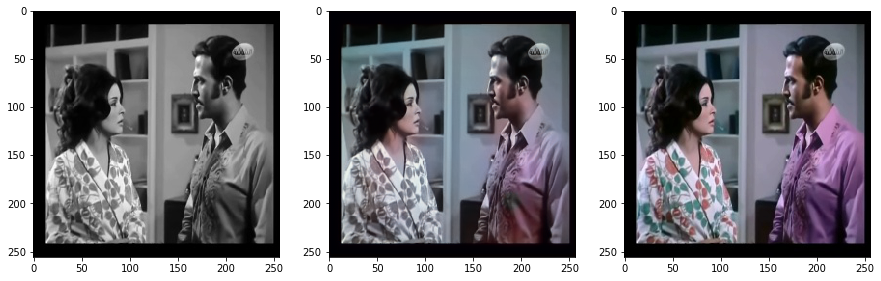

In [11]:
i=2
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1); plt.imshow(x_orig[i][:,:,0], cmap='gray')
plt.subplot(1, 3, 2); plt.imshow(new_img[i])
plt.subplot(1, 3, 3); plt.imshow(y_orig[i])

In [0]:
for i in range(5):
  cv2.cv2.imwrite('/content/drive/My Drive/data_b7b_elcima/'+str(i)+'.jpg', x_orig[i][:,:,0])